In [55]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io as io
import torch.utils.data as Data
from sklearn import datasets

(82, 65, 3)


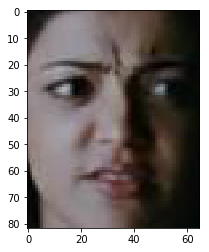

In [57]:
im = io.imread('../data/faces/KajolAggarwal_99.jpg')
print im.shape

plt.imshow(im)

In [58]:

#ds.data.shape
ds.target.shape

(1797,)

In [59]:
# ds = pd.read_csv('../data/fashionmnist/fashion-mnist_train.csv').values
# print ds.shape

In [60]:
# for index,rows in ds.iterrows():
#     print (rows.shape)

In [61]:
# Data Preparation
X_train = ds.data[:1000].reshape((-1, 1, 8, 8)) / 255.0
y_train = ds.target[:1000]

X_test = ds.data[1000:1797].reshape((-1, 1, 8, 8)) / 255.0
y_test = ds.target[1000:1797]
# y_train = one_hot(y_train_labels, 10)

print X_train.shape, y_train.shape,X_test.shape,y_test.shape


(1000, 1, 8, 8) (1000,) (797, 1, 8, 8) (797,)


In [32]:
class CAE(torch.nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        #has 2 convolution operation 1 converts it to 16 
        #downsample
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        #optional in order to diff encoder and decoder
        self.enc_linear=nn.Linear(8*2*2,2)
        self.dec_linear=nn.Linear(2,8*2*2)
        #upsample
        #deconv was used before transpose came into picture
        #unpooling is reverse of pool function
        #they both were ambiguous hence tanspse came into pictre
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            #to convert to 0-1
            nn.Sigmoid()
        )
    def encode(self,x):
        x=self.encoder(x)
        x=x.view(x.size(0),-1)
        #x passed to a fully connected layer
        x=self.enc_linear(x)
        return x #it is a 2d vector
        
    def decode(self,x):
        x=self.dec_linear(x) #converted to 32 
        x=x.view(x.size(0),8,2,2) #reshaping to number of examples,8X2X2
        x=self.decode(x) 
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    # if encode and decode are not used seperatly
  #   def forward(self, x):
   #     x = self.encoder(x)
    #    x = self.decoder(x)
     #   return x

In [33]:
model = CAE()
type(model)

__main__.CAE

In [34]:
model.encode

<bound method CAE.encode of CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_linear): Linear(in_features=32, out_features=2, bias=True)
  (dec_linear): Linear(in_features=2, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)>

In [35]:
# model(torch.FloatTensor(X_train[:1])).min()

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
loss_func = torch.nn.MSELoss()
type(loss_func)

torch.nn.modules.loss.MSELoss

In [38]:
def make_batch(train, labels, batch_size=10, gpu=False):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        if gpu:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.FloatTensor(train[start:stop])).cuda()
        else:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True), Variable(torch.FloatTensor(train[start:stop]))
        start = stop
        stop = start + batch_size

In [44]:
for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 25,False)):
    #print b_x.shape
    print model(b_x).shape

    # gives batch data, normalize x when iterate train_loader
    


RuntimeError: Given input size: (8x1x1). Calculated output size: (8x0x0). Output size is too small at /pytorch/aten/src/THNN/generic/SpatialDilatedMaxPooling.c:67

In [40]:
for epoch in range(100):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 25,False)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = model(b_x)      # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y) # cross entropy loss
        type(loss_func)
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in model.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if step % 200 == 0:
            test_output = model(torch.FloatTensor(X_test))
            test_loss = (loss_func(test_output, torch.FloatTensor(X_test)))
            acc = test_loss.data.numpy()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

RuntimeError: Given input size: (8x1x1). Calculated output size: (8x0x0). Output size is too small at /pytorch/aten/src/THNN/generic/SpatialDilatedMaxPooling.c:67

In [168]:
#model.cpu()
# model.cuda()

(1, 1, 28, 28)
p = (1, 1, 28, 28)


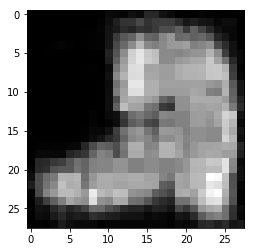

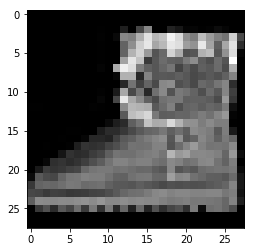

In [174]:
a=12
b=a+1
o = model(torch.FloatTensor(X_train[a:b])).data.numpy()
emb=model.encode(torch.FloatTensor(X_train[:1000])).data.numpy()
plt.figure(0)
plt.imshow(o.reshape((28, 28)), cmap='gray')
print o.shape
plt.figure(1)
plt.imshow(X_train[a:b].reshape((28, 28)), cmap='gray')

p=model(torch.FloatTensor(X_test[a:b])).data.numpy()
embp=model.encode(torch.FloatTensor(X_test[:100])).data.numpy()

print 'p =',p.shape

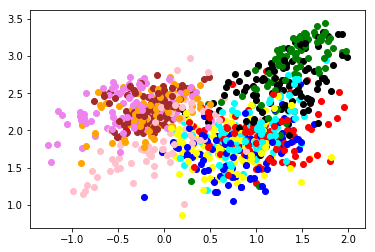

In [173]:
colors = ['red', 'green', 'blue', 'black', 'cyan', 'orange', 'yellow', 'brown', 'pink', 'violet']

for ix in range(emb.shape[0]):
    plt.scatter(emb[ix, 0], emb[ix, 1], color=colors[y_train[ix]])
plt.show()

In [204]:
# for a in range(X_test.shape[0]):
#     p = model(torch.FloatTensor(X_test[a:a+1])).data.numpy()
#     emb=model.encode(torch.FloatTensor(X_test[:1000])).data.numpy()
#     plt.figure(a)
#     plt.imshow(p.reshape((28, 28)), cmap='gray')

In [205]:
def eucladian_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [211]:
test=1
listOfDist={}
testImage=14
p=model.encode(torch.FloatTensor(X_test[testImage:testImage+1])).detach().numpy().reshape(2)
for ix in range(X_train.shape[0]):
    o=model.encode(torch.FloatTensor(X_train[ix:ix+1])).detach().numpy().reshape(2)
    #print o
    #print p
    listOfDist[ix]=eucladian_distance(o,p)
    
#print (listOfDist.sort)
#arr = np.asarray(sorted(listOfDist))
#print listOfDist
#print X_train.shape[0]

In [212]:
finalDict= sorted(listOfDist.iteritems(), key=lambda (k,v): (v,k))
#print finalDict

In [236]:
Bucket=[]
#num=10
for key,values in finalDict:
    if values<.075 :
        Bucket.append(key)
        #num=num-1
    #print values
    #print key,values
    else:
        break
        
#print finalDict        
print Bucket

[5014, 9125, 6896, 5827, 441, 1556, 4229, 316, 9948, 3343, 7141, 7115, 5609, 9302, 1817, 8739, 4653, 1308, 2056, 6746, 6540, 6922, 1431, 5370, 2672, 9855, 5456, 9429, 3537, 4440, 4919, 551, 3823, 1284, 671, 4641, 3620, 8970, 4200, 3945, 7284, 8966, 5555, 6499, 9827, 5927, 4699, 3911, 9489, 8202, 7474, 1797, 965, 4058, 3579, 5086, 1372, 8590, 4988, 971, 5139, 7130, 3698, 8490, 8084, 3243, 3123, 5878, 4443, 2427, 5973, 2948, 4126, 8735, 282, 6194, 1002, 7782, 458, 451, 8622, 3775, 3922, 2702, 3899, 5378, 4259, 1555, 1862, 5553, 1924, 9198, 3586, 9090, 4562, 5994, 897, 6191, 1994, 1095, 6420, 2372, 4597, 5739, 6929, 8017, 528, 2489, 7605, 7872, 8331, 2205, 7504, 3450, 1737, 8500, 8561, 8089, 2802, 9002, 4888, 9273, 3847, 1767, 5358, 5228, 3732, 6591, 6845, 8990, 9246, 7881, 8353, 2536, 7078, 1314, 8834, 7412, 3905, 7082, 6346, 6374, 5865, 8171, 4918, 6171, 8410, 8361, 6437, 9605, 8044, 275, 8612, 5898, 9368, 1597, 1370, 9802, 7167, 2134, 8997, 9500, 296, 2812]


4


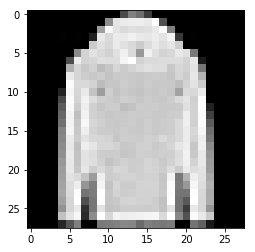

2


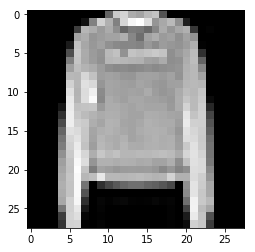

6


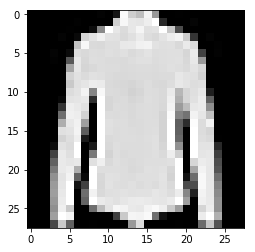

6


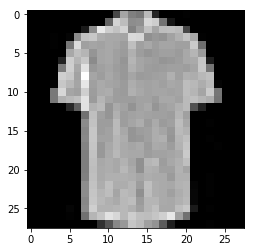

0


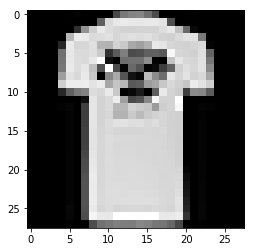

0


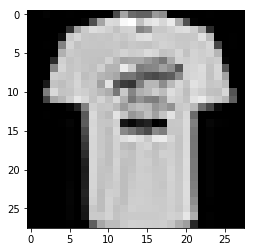

6


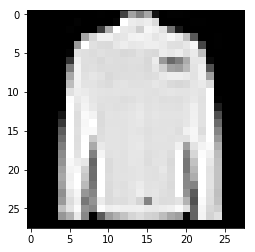

0


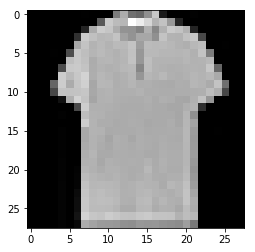

6


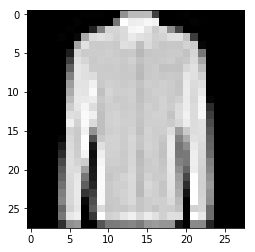

2


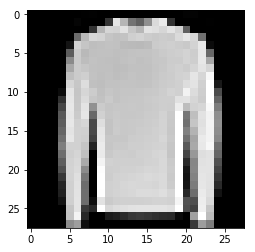

4


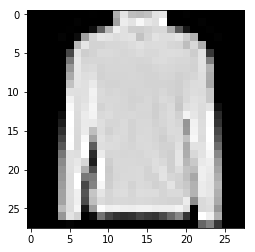

2


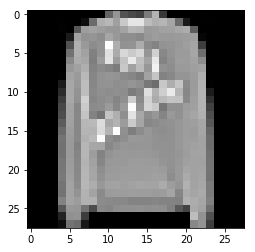

2


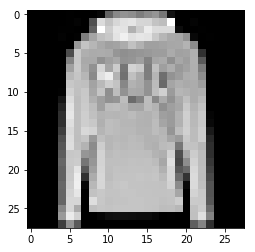

3


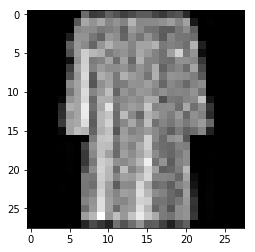

6


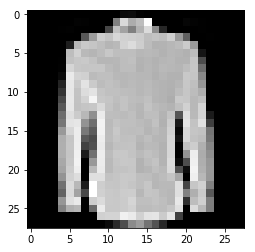

4


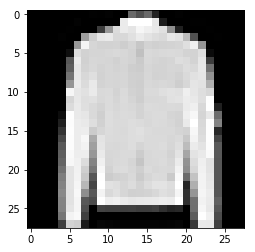

0


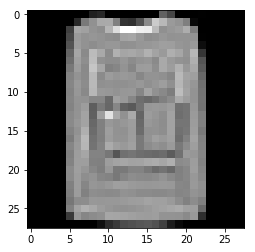

0


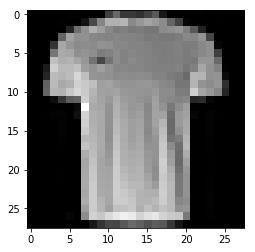

1


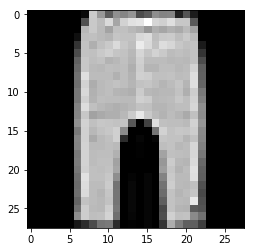

0


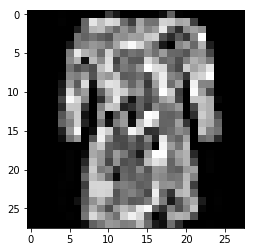

4


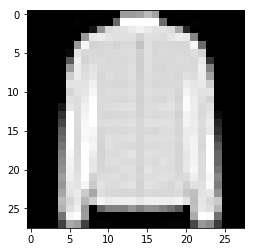

2


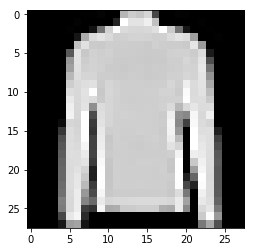

6


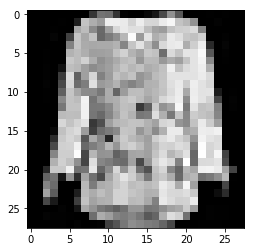

6


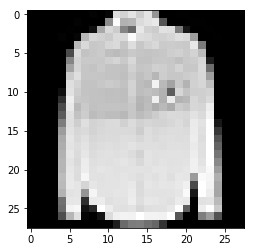

0


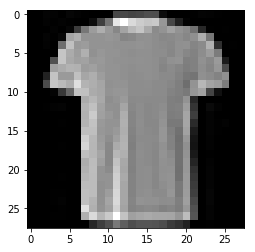

4


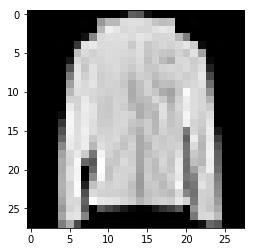

6


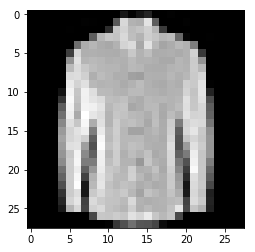

4


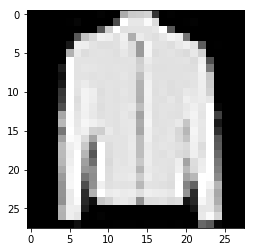

0


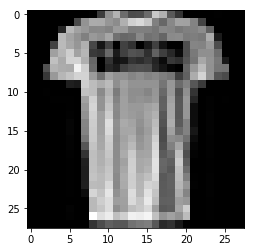

4


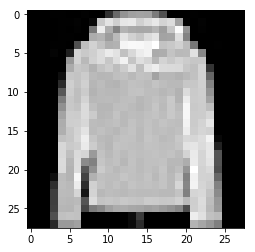

0


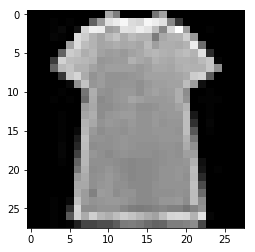

2


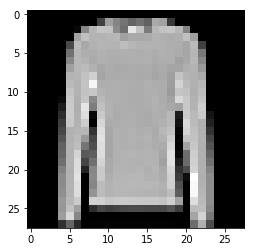

2


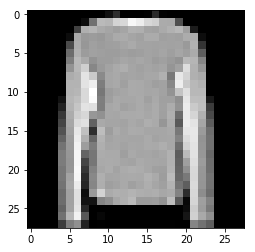

2


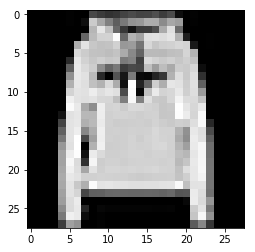

4


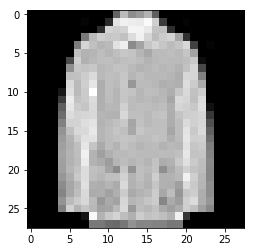

0


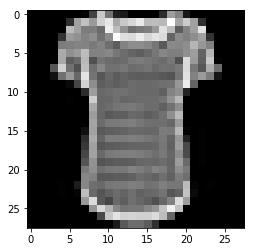

2


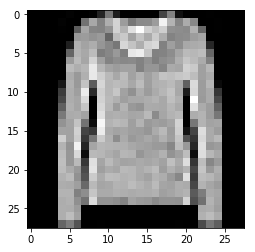

4


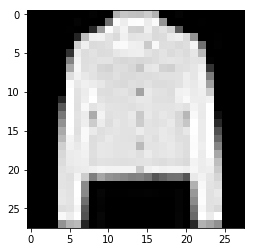

2


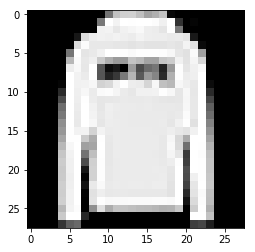

4


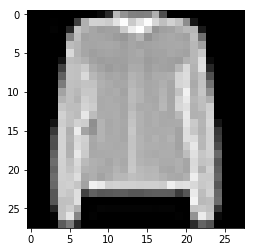

6


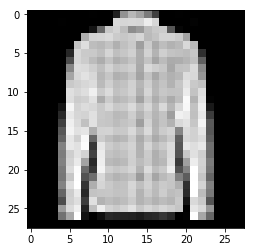

4


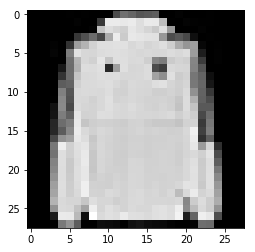

4


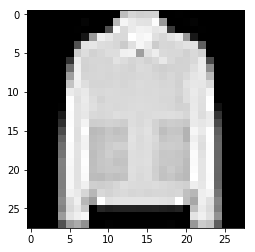

6


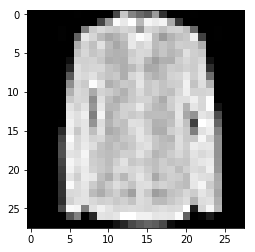

0


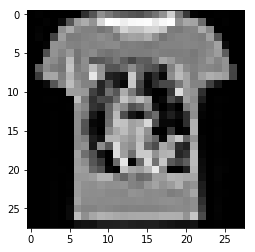

4


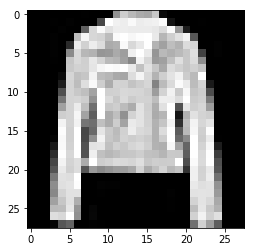

6


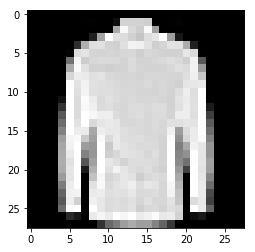

6


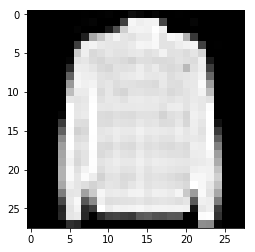

4


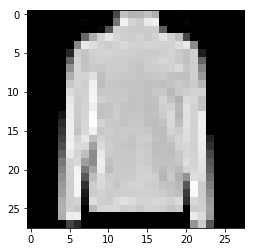

4


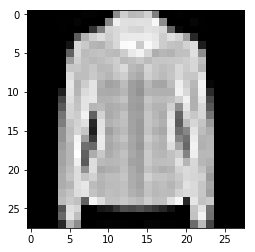

6


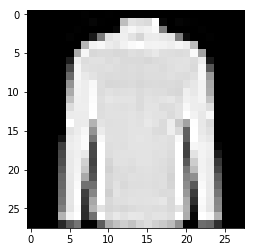

0


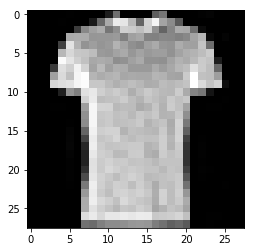

0


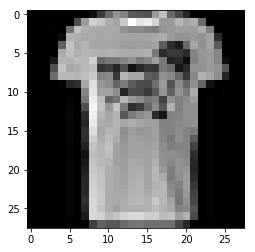

3


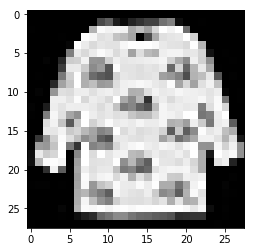

4


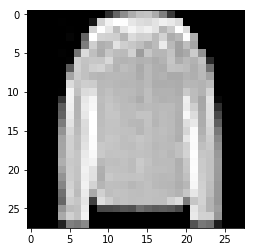

2


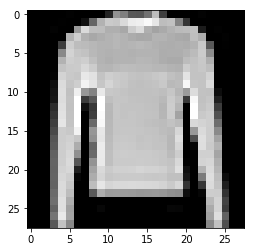

2


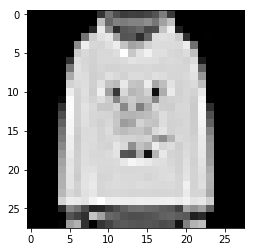

4


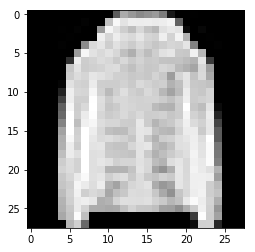

0


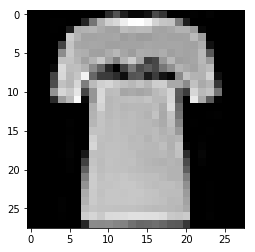

6


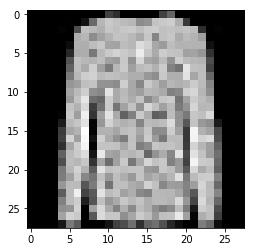

2


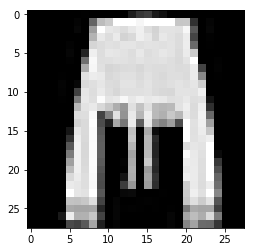

6


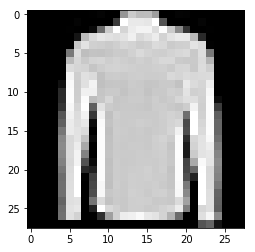

4


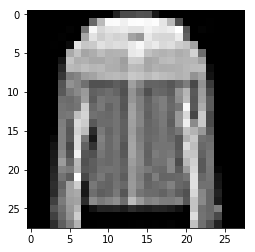

6


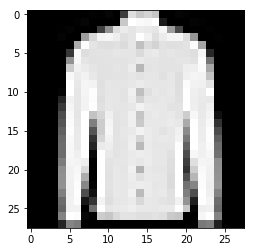

3


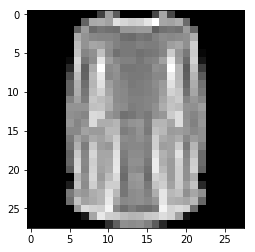

4


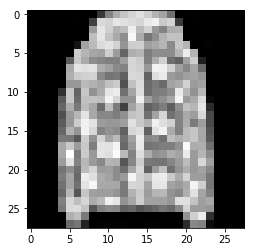

6


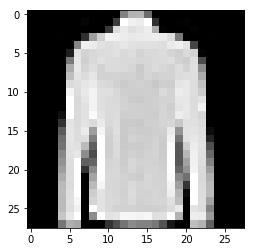

2


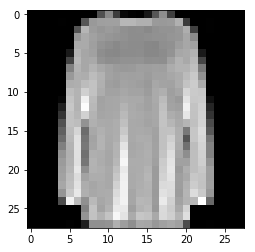

0


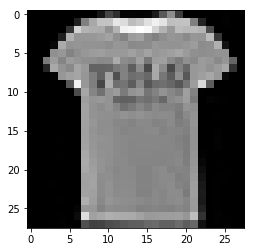

2


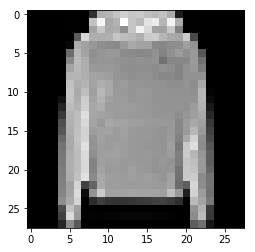

3


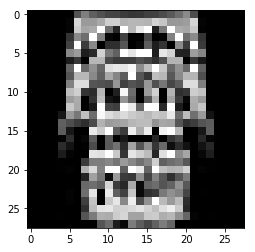

4


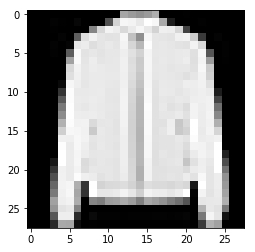

0


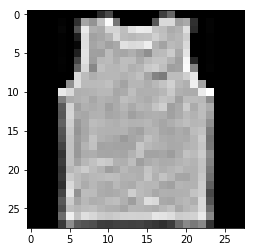

6


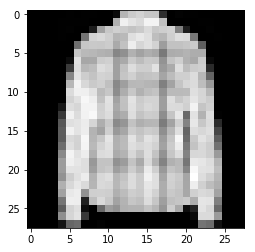

2


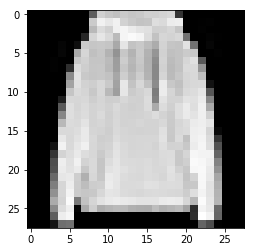

0


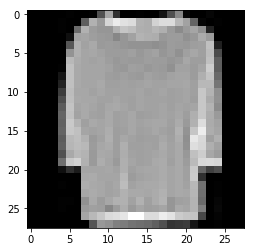

6


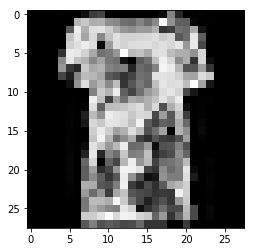

6


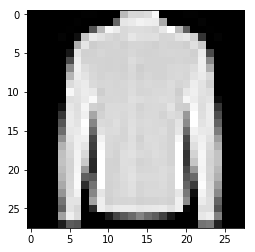

6


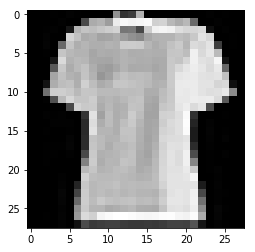

4


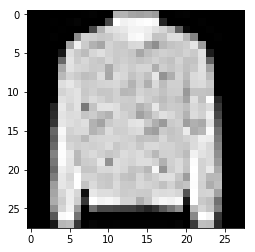

0


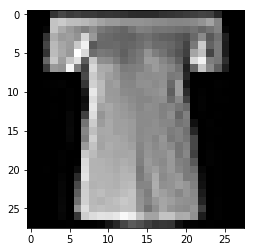

6


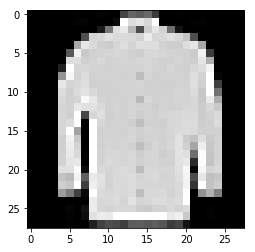

4


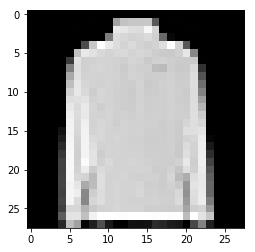

6


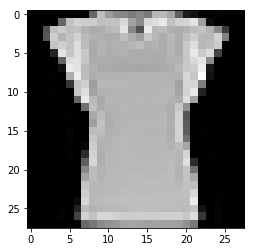

4


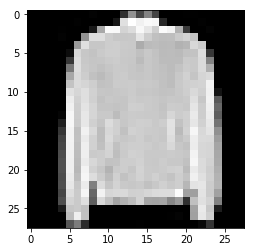

4


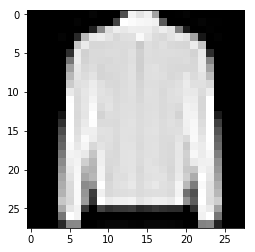

0


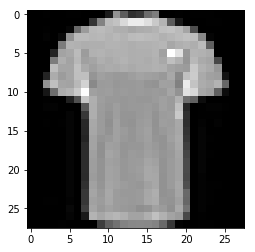

6


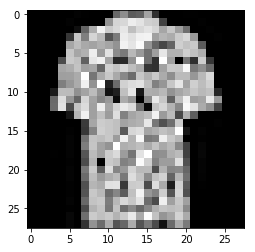

4


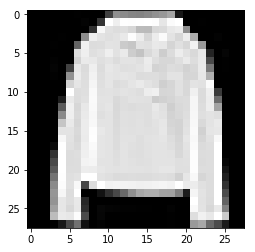

6


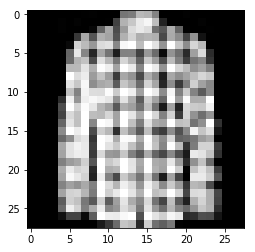

3


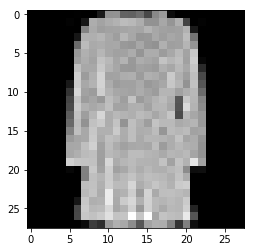

6


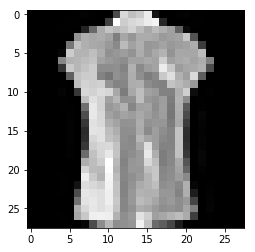

6


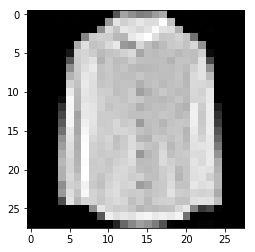

0


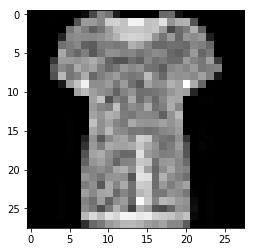

6


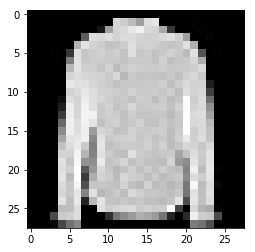

2


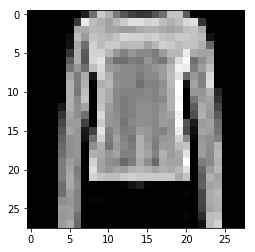

4


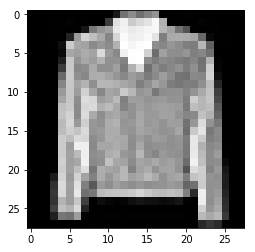

3


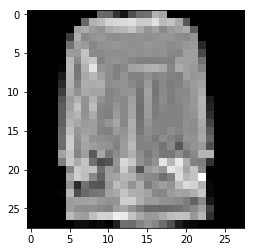

2


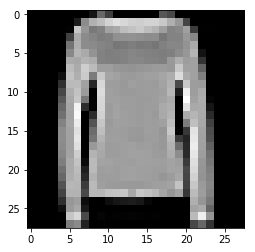

0


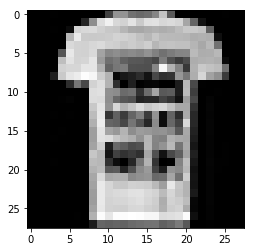

6


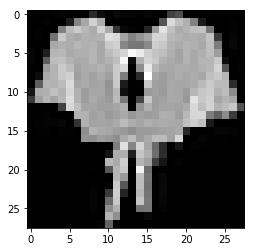

4


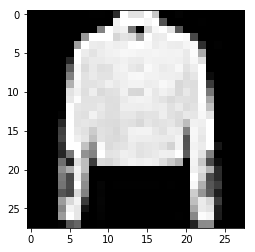

4


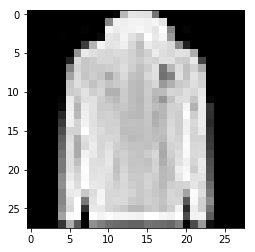

4


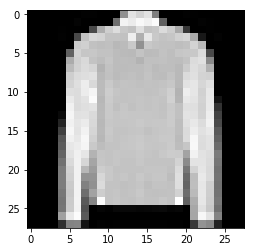

0


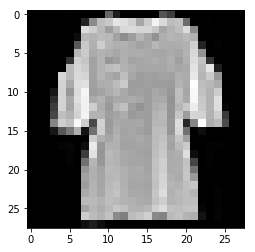

4


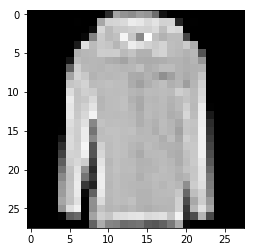

4


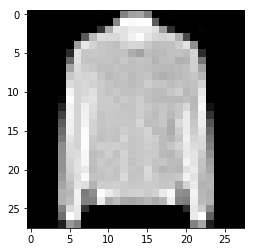

6


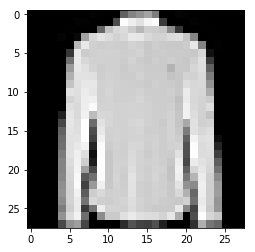

4


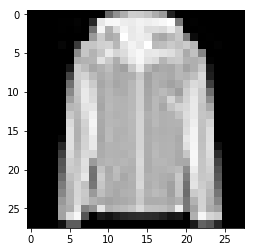

4


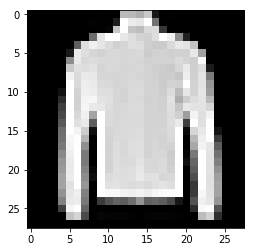

4


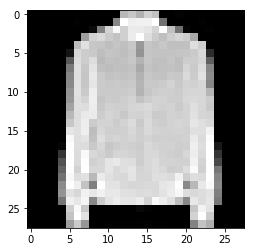

2


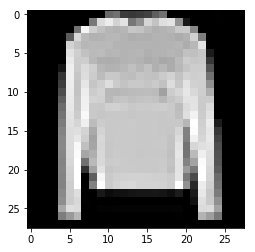

0


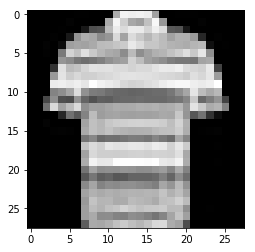

2


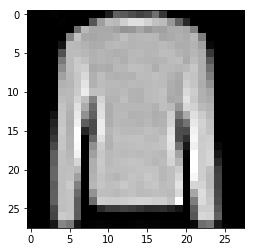

0


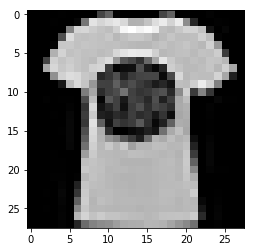

6


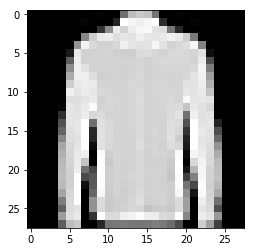

2


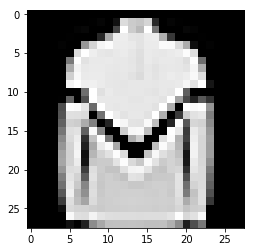

2


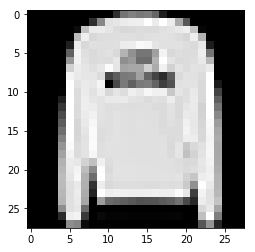

6


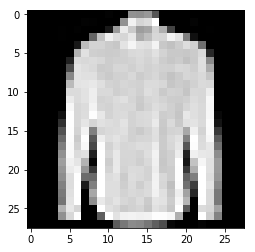

6


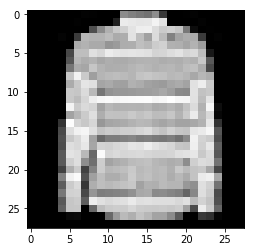

6


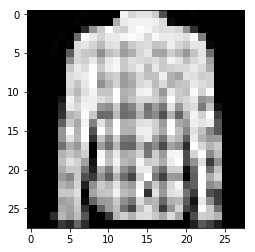

4


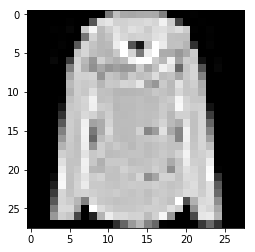

6


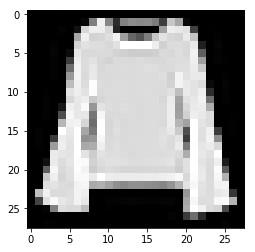

4


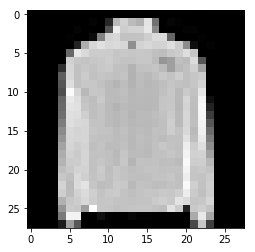

2


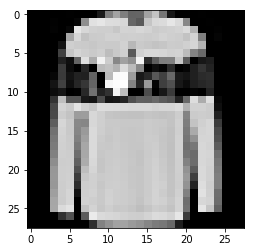

6


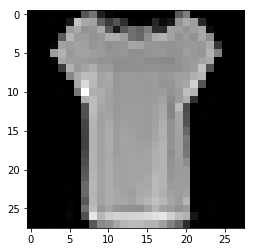

6


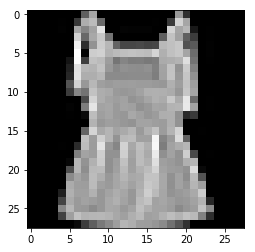

4


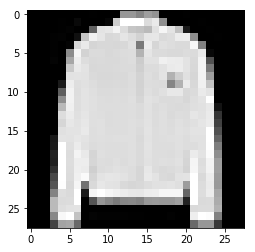

6


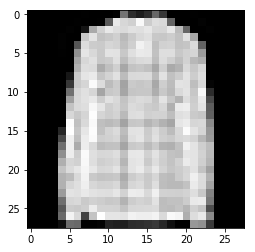

0


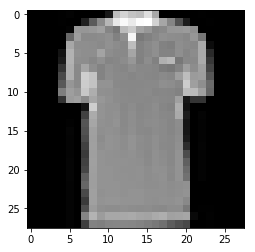

6


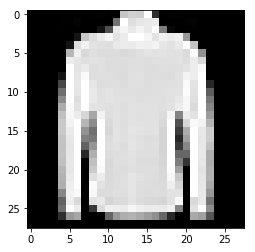

4


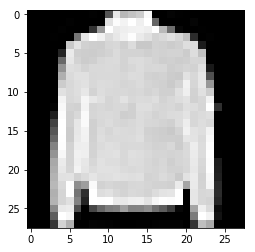

2


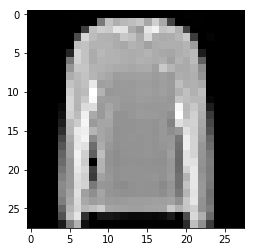

0


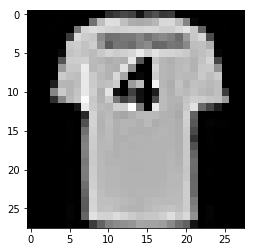

4


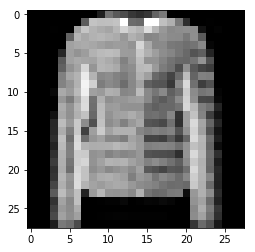

6


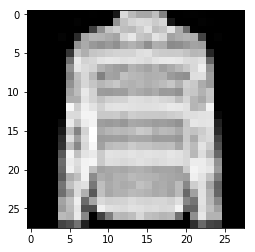

0


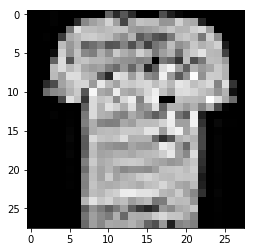

0


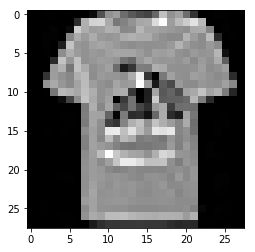

6


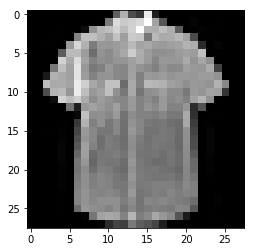

4


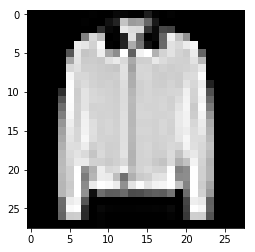

4


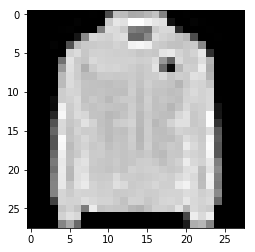

0


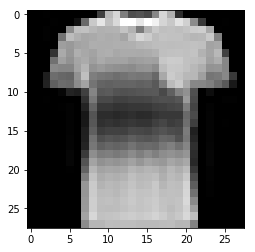

4


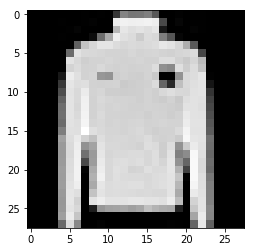

2


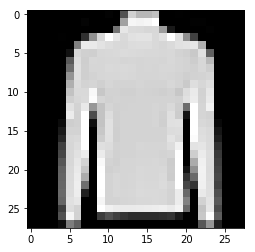

2


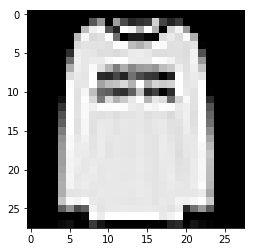

2


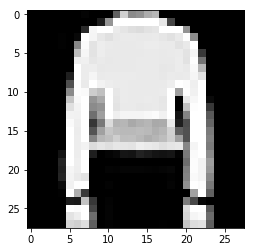

6


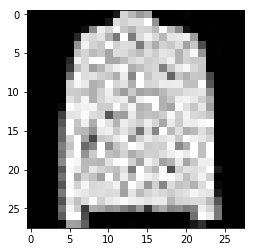

4


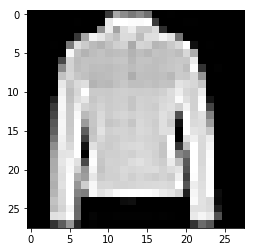

4


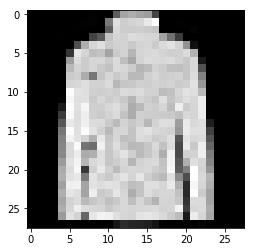

4


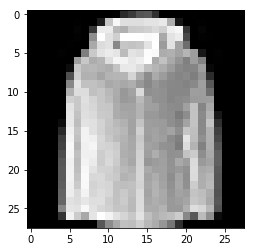

4


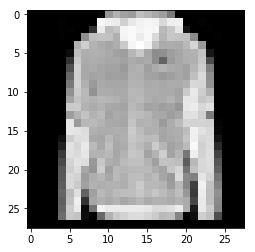

2


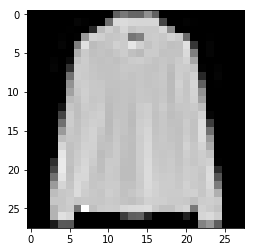

0


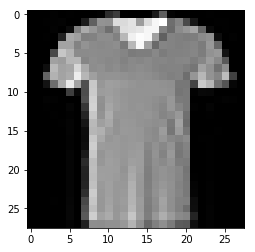

6


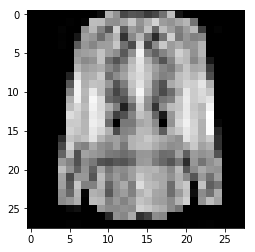

4


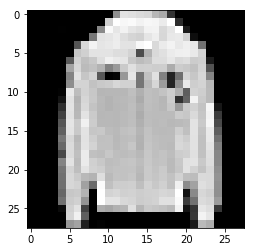

2


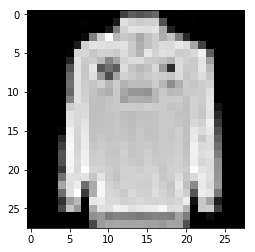

0


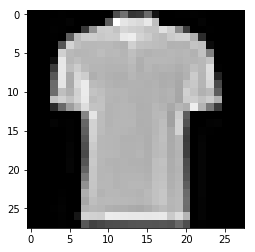

0


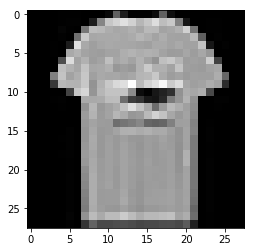

6


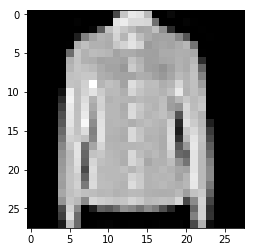

3


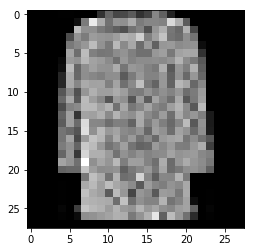

2


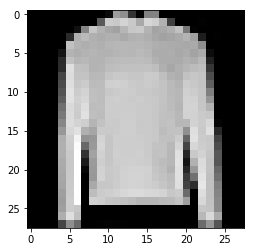

4


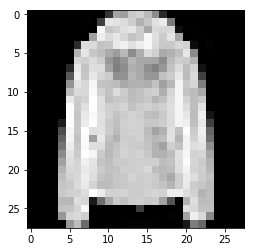

4


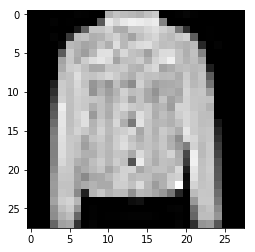

2


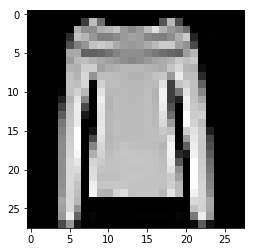

In [237]:
for ix in Bucket:
    plt.figure(0)
    plt.imshow(X_train[ix:ix+1].reshape(28,28),cmap='gray')
    print y_train[ix]
    plt.show()


4


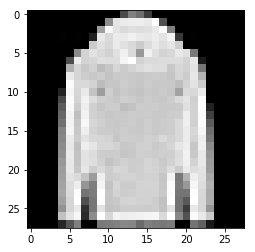

In [235]:
    plt.figure(1)
    plt.imshow(X_test[testImage:testImage+1].reshape(28,28),cmap='gray')
    print y_test[testImage]
    plt.show()

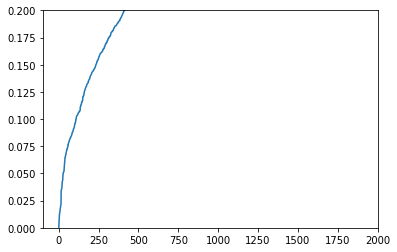

In [195]:
plt.figure(0)
plt.plot(arr)
plt.xlim(-100,2000)
plt.ylim(0,.2)
plt.show()